In [1]:
# Import necessary libraries
import pandas as pd
import requests
import json
import influxdb_client
from influxdb import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#AUTOMATION AREA
# 1) Get company tickers to format URL string
# 2) Format string as such: "https://financialmodelingprep.com/api/v3/income-statement/" + companyName + "?datatype=csv&apikey=" + API_KEY

In [3]:
# Retrieve local API key from file (---this file is not to be pushed to GitHub for security reasons ---)
keyFile="/home/wintergreen/Projects/fskeyfile.txt"
with open(keyFile) as f:
    key = str(f.readline().replace("\n",""))
API_KEY = key

In [4]:
TICKER_TARGET = "AMZN"

In [5]:
URL = "https://financialmodelingprep.com/api/v3/income-statement/" + TICKER_TARGET + "?limit=120&apikey=" + API_KEY

In [6]:
# Make request for data
r = requests.get(URL)

In [7]:
r = r.json()

In [8]:
pd.DataFrame.from_dict(r)

,date,symbol,reportedCurrency,fillingDate,acceptedDate,period,revenue,costOfRevenue,grossProfit,grossProfitRatio,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
0,2019-12-31,AMZN,USD,2020-01-31 00:00:00,2020-01-30 20:46:13,FY,280522000000,205768000000,74754000000,0.266482,...,0.049821,2374000000,11588000000,0.041309,23.46,23.01,494000000,504000000,https://www.sec.gov/Archives/edgar/data/101872...,https://www.sec.gov/Archives/edgar/data/101872...
1,2018-12-31,AMZN,USD,2019-02-01 00:00:00,2019-01-31 20:22:40,FY,232887000000,173183000000,59704000000,0.256365,...,0.048354,1197000000,10073000000,0.043253,20.68,20.14,487000000,500000000,https://www.sec.gov/Archives/edgar/data/101872...,https://www.sec.gov/Archives/edgar/data/101872...
2,2017-12-31,AMZN,USD,2018-02-02 00:00:00,2018-02-01 20:41:15,FY,177866000000,137183000000,40683000000,0.228728,...,0.021398,769000000,3033000000,0.017052,6.32,6.15,480000000,493000000,https://www.sec.gov/Archives/edgar/data/101872...,https://www.sec.gov/Archives/edgar/data/101872...
3,2016-12-31,AMZN,USD,2017-02-10 00:00:00,2017-02-09 17:56:36,FY,135987000000,105884000000,30103000000,0.221367,...,0.028620,1425000000,2371000000,0.017435,5.01,4.90,474000000,484000000,https://www.sec.gov/Archives/edgar/data/101872...,https://www.sec.gov/Archives/edgar/data/101872...
4,2015-12-31,AMZN,USD,2016-01-29 00:00:00,2016-01-28 19:38:11,FY,107006000000,85061000000,21945000000,0.205082,...,0.014653,950000000,596000000,0.005570,1.28,1.25,467000000,477000000,https://www.sec.gov/Archives/edgar/data/101872...,https://www.sec.gov/Archives/edgar/data/101872...


In [9]:
# Prepare the data
#print(pd.DataFrame.from_dict(r))
data = ((pd.DataFrame.from_dict(r)).sort_values(by=['fillingDate'])).reset_index()

print(data.columns)

# Combine SellingAndMarketing and generalAndAdministrative into one SGA Cost
data['SellingGeneralAdministrative'] = data.apply(lambda row: row.generalAndAdministrativeExpenses + (row.sellingAndMarketingExpenses), axis=1)

data['SGA_%_GP'] = data.apply(lambda row: row.SellingGeneralAdministrative / (row.grossProfit)*100, axis=1)
data['RD_%_GP'] = data.apply(lambda row: row.researchAndDevelopmentExpenses / (row.grossProfit)*100, axis=1)
data['grossProfitMargin'] = data.apply(lambda row: row.grossProfitRatio * 100,axis=1)
data['NE_%_RV'] = data.apply(lambda row: (row.netIncome / row.revenue) * 100,axis=1)


# Gather metrics needed for linear time-series graphs
revGrossNet=data[['fillingDate','revenue','grossProfit','netIncome']]
grossProfitMargin = data[['fillingDate','grossProfitMargin']]
SGA_RD_GP = data[['fillingDate','SGA_%_GP','RD_%_GP']]
rev = data[['fillingDate','revenue']]
NE_RV = data[['fillingDate','NE_%_RV']]
perShareEarnings = data[['fillingDate','eps']]

Index(['index', 'date', 'symbol', 'reportedCurrency', 'fillingDate',
       'acceptedDate', 'period', 'revenue', 'costOfRevenue', 'grossProfit',
       'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'otherExpenses', 'operatingExpenses', 'costAndExpenses',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio',
       'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
       'incomeBeforeTaxRatio', 'incomeTaxExpense', 'netIncome',
       'netIncomeRatio', 'eps', 'epsdiluted', 'weightedAverageShsOut',
       'weightedAverageShsOutDil', 'link', 'finalLink'],
      dtype='object')


AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755)


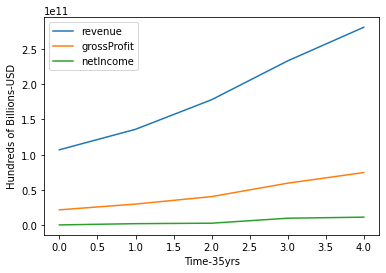

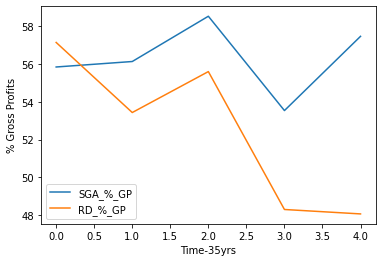

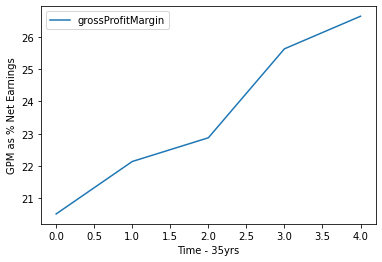

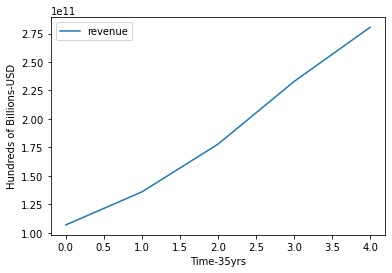

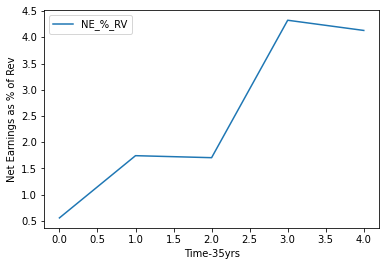

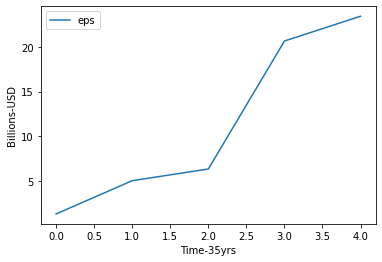

In [11]:
# Plot the data
#plt.figure()
rgnPlot = revGrossNet.plot()
rgnPlot.set_ylabel('Hundreds of Billions-USD')
rgnPlot.set_xlabel('Time-35yrs')

sgardPlot = SGA_RD_GP.plot()
sgardPlot.set_ylabel('% Gross Profits')
sgardPlot.set_xlabel('Time-35yrs')

gpmPlot = grossProfitMargin.plot()
gpmPlot.set_ylabel('GPM as % Net Earnings')
gpmPlot.set_xlabel('Time - 35yrs')

revPlot = rev.plot()
revPlot.set_ylabel('Hundreds of Billions-USD')
revPlot.set_xlabel('Time-35yrs')

nervPlot = NE_RV.plot()
nervPlot.set_ylabel('Net Earnings as % of Rev')
nervPlot.set_xlabel('Time-35yrs')

eps = perShareEarnings.plot()
eps.set_ylabel('Billions-USD')
eps.set_xlabel('Time-35yrs')

print(rgnPlot, sgardPlot, gpmPlot,revPlot,nervPlot,eps)